## Portfolio Part 3

In this Portfolio task, you will continue working with the dataset you have used in portfolio 2. But the difference is that the rating column has been changed with like or dislike values. Your task is to train classification models to predict whether a user like or dislike an item.  


The header of the csv file is shown below. 

| userId | timestamp | review | item| rating | helpfulness | gender | category |
    | ---- | ---- | ---- | ---- | ---- | ---- | ---- | ---- | 
    
#### Description of Fields

* __userId__ - the user's id
* __timestamp__ - the timestamp indicating when the user rated the shopping item
* __review__ - the user's review comments of the item
* __item__ - the name of the item
* __rating__ - the user like or dislike the item
* __helpfulness__ - average rating from other users on whether the review comment is helpful. 6-helpful, 0-not helpful. 
* __gender__ - the gender of the user, F- female, M-male
* __category__ - the category of the shopping item


Your high level goal in this notebook is to try to build and evaluate predictive models for 'rating' from other available features - predict the value of the __rating__ field in the data from some of the other fields. More specifically, you need to complete the following major steps: 
1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.
2) Convert object features into digit features by using an encoder
3) Study the correlation between these features. 
4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.
5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.
6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance

Note 1: We did not provide any description of each step in the notebook. You should learn how to properly comment your notebook by yourself to make your notebook file readable. 

Note 2: you are not being evaluated on the ___accuracy___ of the model but on the ___process___ that you use to generate it. Please use both ___Logistic Regression model___ and ___KNN model___ for solving this classification problem. Accordingly, discuss the performance of these two methods.

## Exploratory Data Analysis

#### <i>1) Explore the data. Clean the data if necessary. For example, remove abnormal instanaces and replace missing values.</i>

In [1]:
#import Libraries First
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score

import warnings
warnings.filterwarnings('ignore')

Read the CSV and outout the intial 5 rows

In [2]:
df = pd.read_csv('data/Portfolio 3.csv')
df.head(5)

,userId,timestamp,review,item,rating,helpfulness,gender,category
0,4259,11900,"Finally, Something for (Relatively) Nothing",MyPoints.com,like,4,F,Online Stores & Services
1,4259,12000,Shocking!,Sixth Sense,like,4,F,Movies
2,4259,12000,Simply Shaggadelic!,Austin Powers: The Spy Who Shagged Me,like,4,F,Movies
3,4259,12000,Better Than The First!,Toy Story 2,like,3,F,Movies
4,4259,12000,Blair Witch made me appreciate this,Star Wars Episode I: The Phantom Menace,dislike,4,F,Movies


Here, we are creating a new dataframe so that we dont mess up the original dataframe. We are also using <i>`info`</i> to show case a consise summary of the dataframe 

In [3]:
productDF = df.copy()
productDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   userId       2899 non-null   int64 
 1   timestamp    2899 non-null   int64 
 2   review       2899 non-null   object
 3   item         2899 non-null   object
 4   rating       2899 non-null   object
 5   helpfulness  2899 non-null   int64 
 6   gender       2899 non-null   object
 7   category     2899 non-null   object
dtypes: int64(3), object(5)
memory usage: 181.3+ KB


Alternatively, we can use <i>`isnull().sum`</i> to return the number of missing values in our dataframe. As seen for both cells (above and below), there are no missing values. Hence, this is a relatively good dataset.

In [4]:
productDF.isnull().sum()

userId         0
timestamp      0
review         0
item           0
rating         0
helpfulness    0
gender         0
category       0
dtype: int64

Below, we're going to check the counts of unique values for each column. 

In [5]:
print('Gender Counts')
productDF.groupby('gender', as_index=False).count()[['gender', 'userId']]

Gender Counts


,gender,userId
0,F,1655
1,M,1244


Text(0.5, 1.0, 'Gender Distribution of Reviews')

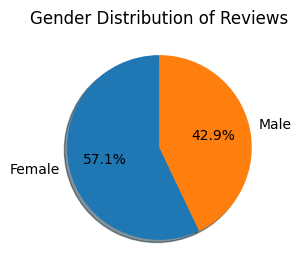

In [6]:
plt.figure(figsize=(3,3))
label = 'Female','Male'
plt.pie([len(productDF['gender'][productDF['gender']=='F']),len(productDF['gender'][productDF['gender']=='M'])],labels=label,autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Gender Distribution of Reviews')

In [7]:
print('Distribution of Likes and Dislikes')
productDF.groupby('rating', as_index=False).count()[['rating', 'userId']]

Distribution of Likes and Dislikes


,rating,userId
0,dislike,1050
1,like,1849


Text(0.5, 1.0, 'Gender Distribution of Reviews')

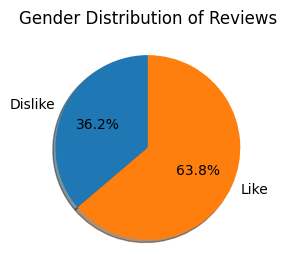

In [8]:
plt.figure(figsize=(3,3))
label = 'Dislike','Like'
plt.pie([len(productDF['rating'][productDF['rating']=='dislike']),len(productDF['rating'][productDF['rating']=='like'])],labels=label,autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('Gender Distribution of Reviews')

Above, it is observed that the number of likes outnumbered the number of dislikes.

In [9]:
##Check the unique values for category
pd.DataFrame(productDF['category'].unique())

,0
0,Online Stores & Services
1,Movies
2,Hotels & Travel
3,Games
4,Personal Finance
5,Media
6,Kids & Family
7,Restaurants & Gourmet
8,Books


Currently, we have 9 unique categories. Since it would be a labor to create a pie chart for their distribution, we'll use bar plot here instead.

Text(0, 0.5, 'Count of Reviews')

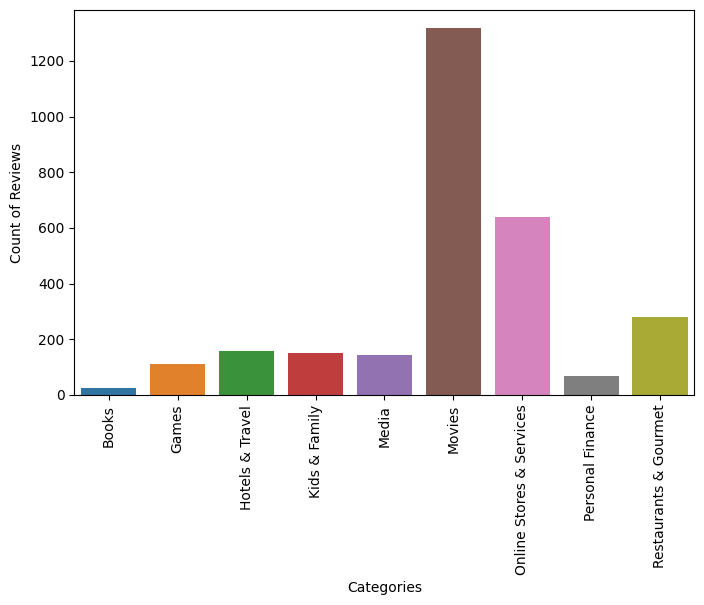

In [10]:
plt.figure(figsize=(8,5))
countCategory = productDF.groupby('category', as_index=False).count()
plt.xticks(rotation=90)
sns.barplot(data=countCategory, x="category", y="userId")
plt.xlabel('Categories')
plt.ylabel('Count of Reviews')

Movies got the highest reviewed category in our dataset.

In [11]:
##Check the unique values for item
pd.DataFrame(productDF['item'].unique())

,0
0,MyPoints.com
1,Sixth Sense
2,Austin Powers: The Spy Who Shagged Me
3,Toy Story 2
4,Star Wars Episode I: The Phantom Menace
...,...
81,X.com
82,Playtex Diaper Genie System
83,Southwest Airlines
84,Huggies Ultra Trim Diapers


The items are too many, but lets attempt to plot it using the barplot

Text(0, 0.5, 'Count of Reviews')

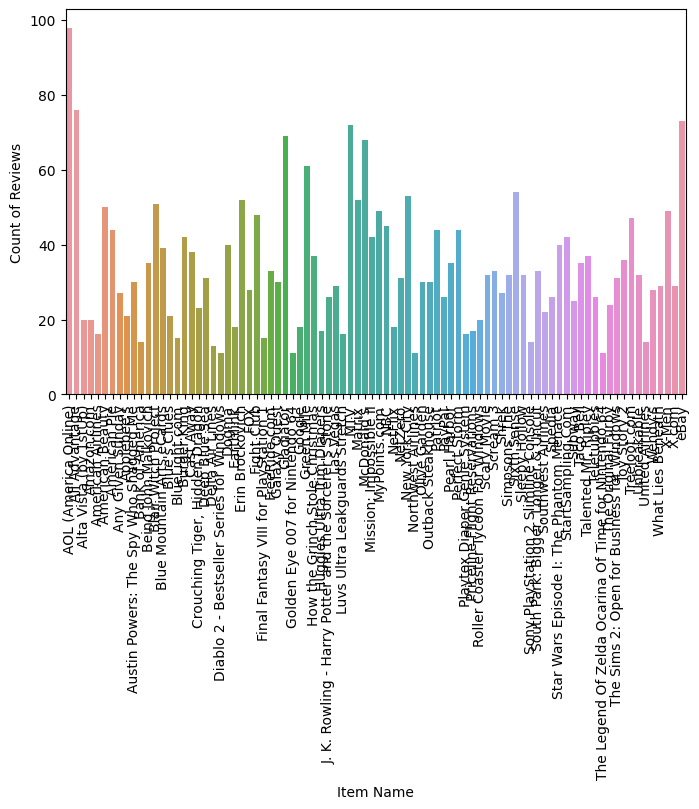

In [12]:
plt.figure(figsize=(8,5))
countItem = productDF.groupby('item', as_index=False).count()
plt.xticks(rotation=90)
sns.barplot(data=countItem, x="item", y="userId")
plt.xlabel('Item Name')
plt.ylabel('Count of Reviews')

Currently, it is very incomprehensible as seen above

In [13]:
import plotly.express as px
itemNames = countItem['item'].values
itemValues = countItem['userId'].values
fig = px.funnel_area(names=itemNames,
                    values=itemValues)
fig.show()


It does not help even we use a funnel graph. The next Fortunately, the items are grouped by category. Therefore we could instead use that to our advantage. Instead of comparing each item to different item, let's try to compare them against the items with the same category.

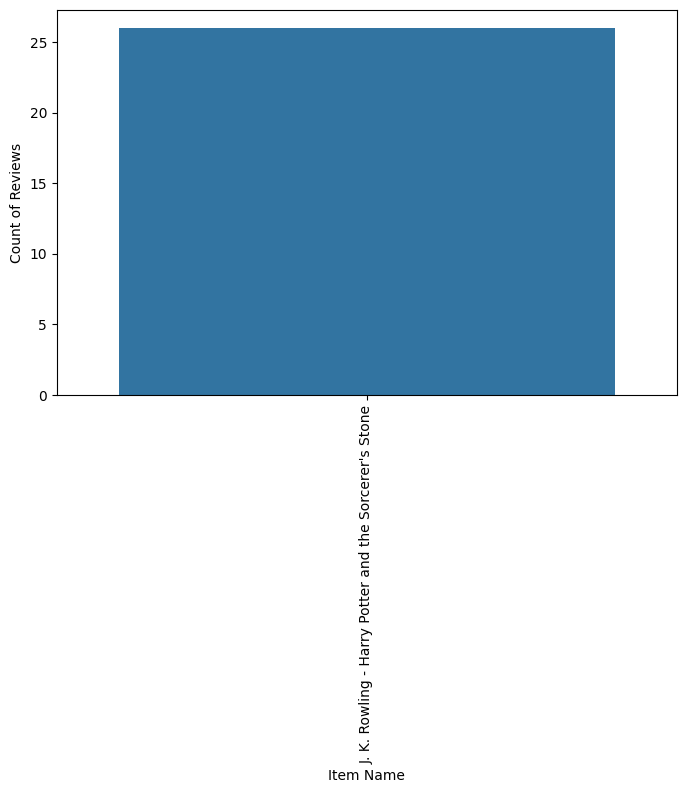

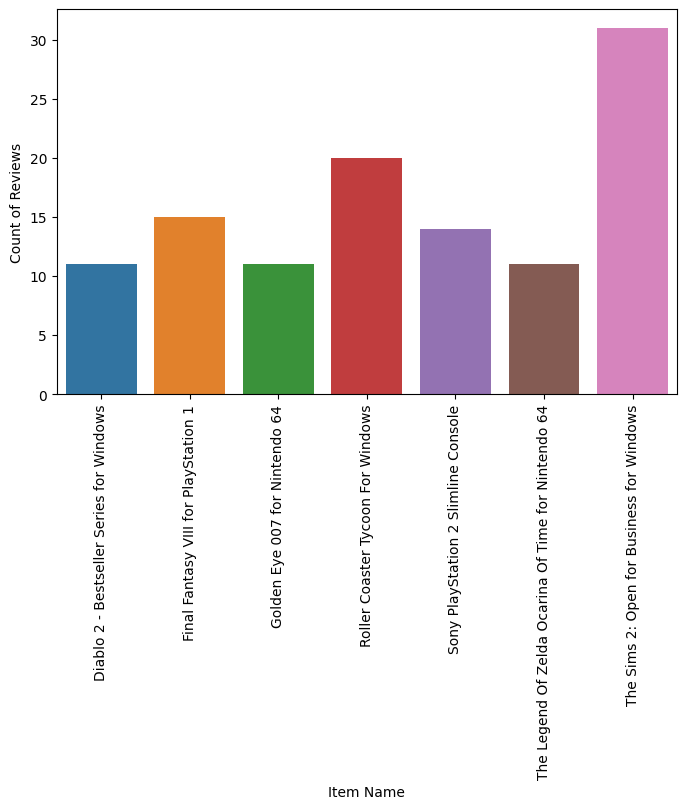

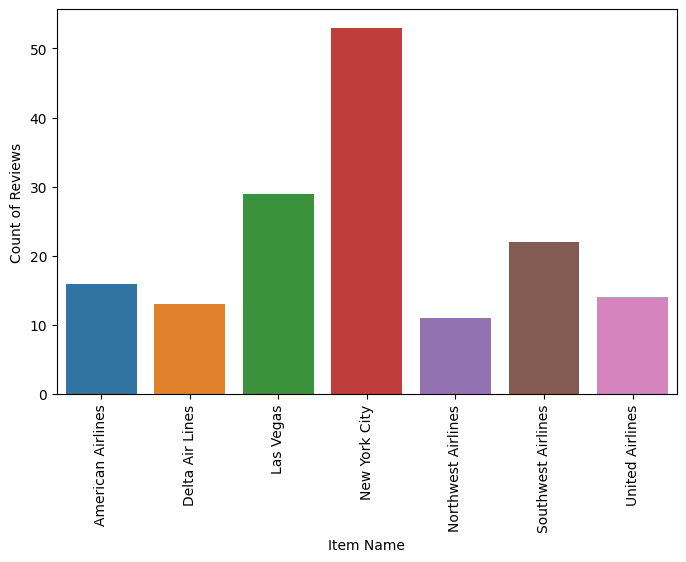

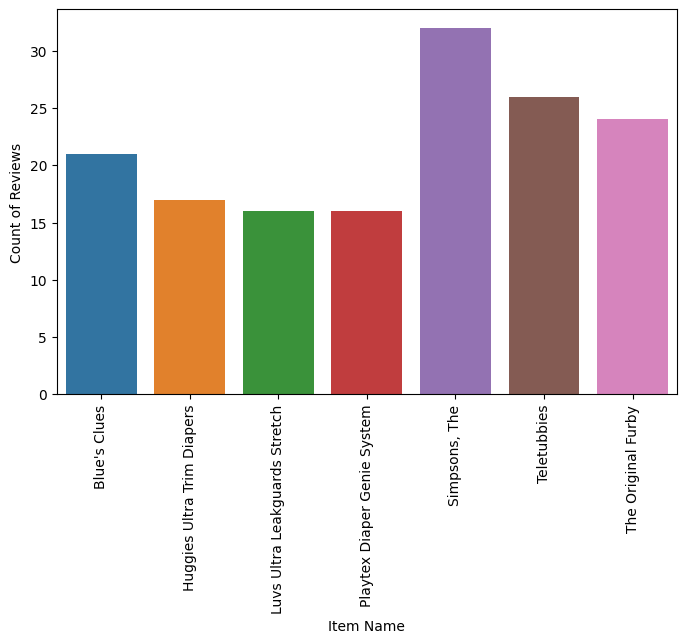

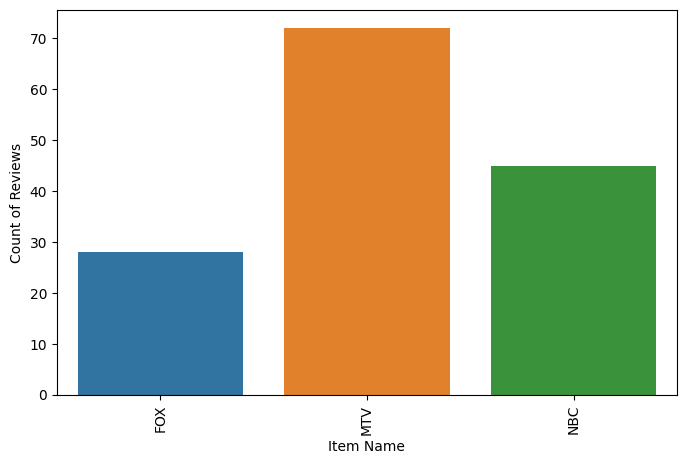

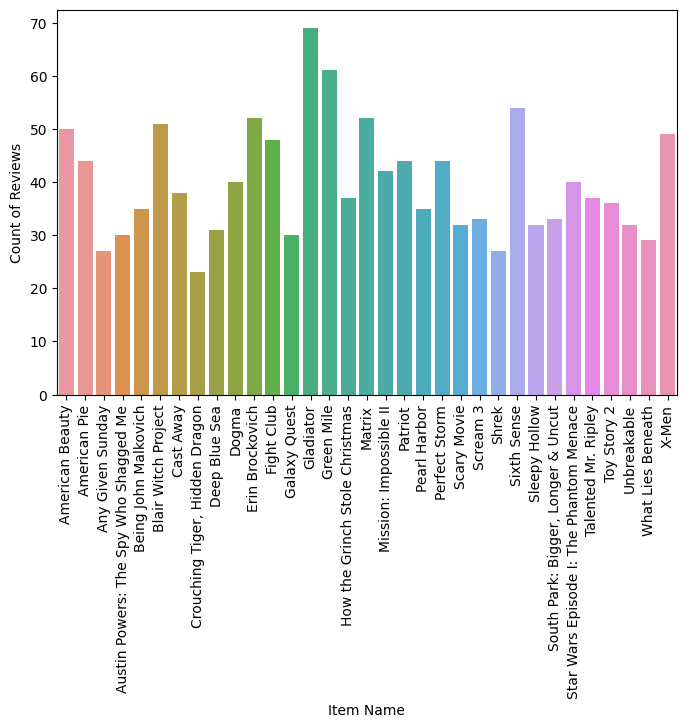

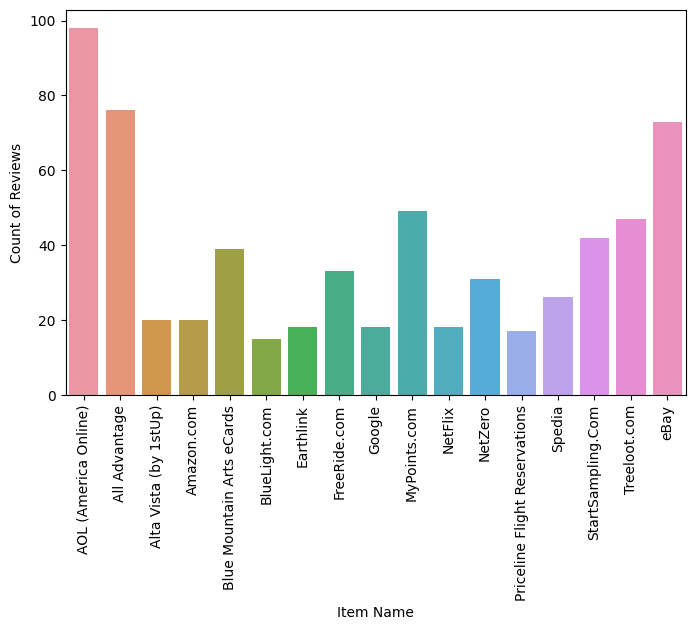

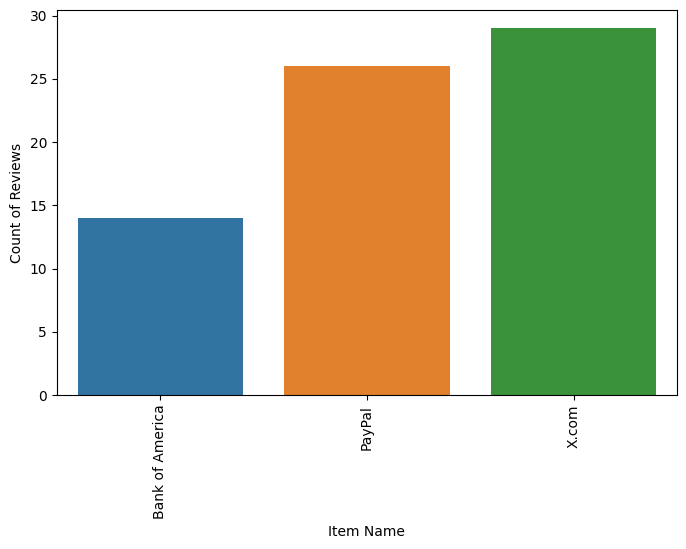

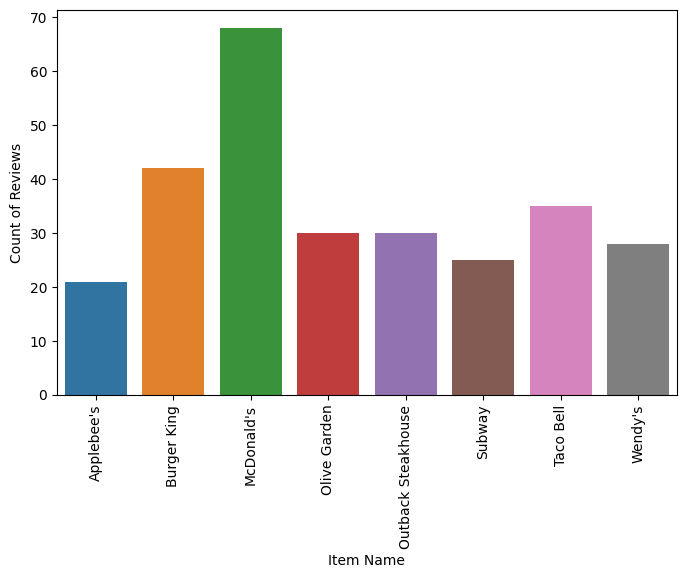

In [14]:
catItemCount = productDF.groupby(['category', 'item']).size().reset_index(name='count')

for col in countCategory['category']:
    tempDF = catItemCount[catItemCount['category'] == col]
    plt.figure(figsize=(8,5))
    plt.xticks(rotation=90)
    sns.barplot(data=tempDF, x="item", y="count")
    plt.xlabel('Item Name')
    plt.ylabel('Count of Reviews')


Looks good so far. With this, we can deduce that certain item got hits from reviews. The next thing we would like to do is to convert the values into numerical one so that we could feed it into our classification algorithm.

#### <i>2) Convert object features into digit features by using an encoder</i>

In [15]:
enc = OrdinalEncoder()
encodedProductDF = productDF.copy()
encodedProductDF[["category","gender", "item", "rating"]] = enc.fit_transform(encodedProductDF[["category","gender", "item", "rating"]])

Check the unique values of our dataframe (encoded). Altho it is a given that most will be in numbers because of the `OrdinalEncoder` we used above.

In [16]:
for col in encodedProductDF.drop(columns=['userId', 'timestamp', 'review']):
    uniqueVal = encodedProductDF[col].unique()
    print(col, sorted(uniqueVal))

item [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0]
rating [0.0, 1.0]
helpfulness [3, 4]
gender [0.0, 1.0]
category [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]


The Pair Plot below helps us visualize the distribution of single variables as well as relationships between two variables. They are a great method to identify trends between variables our follow-up analysis.

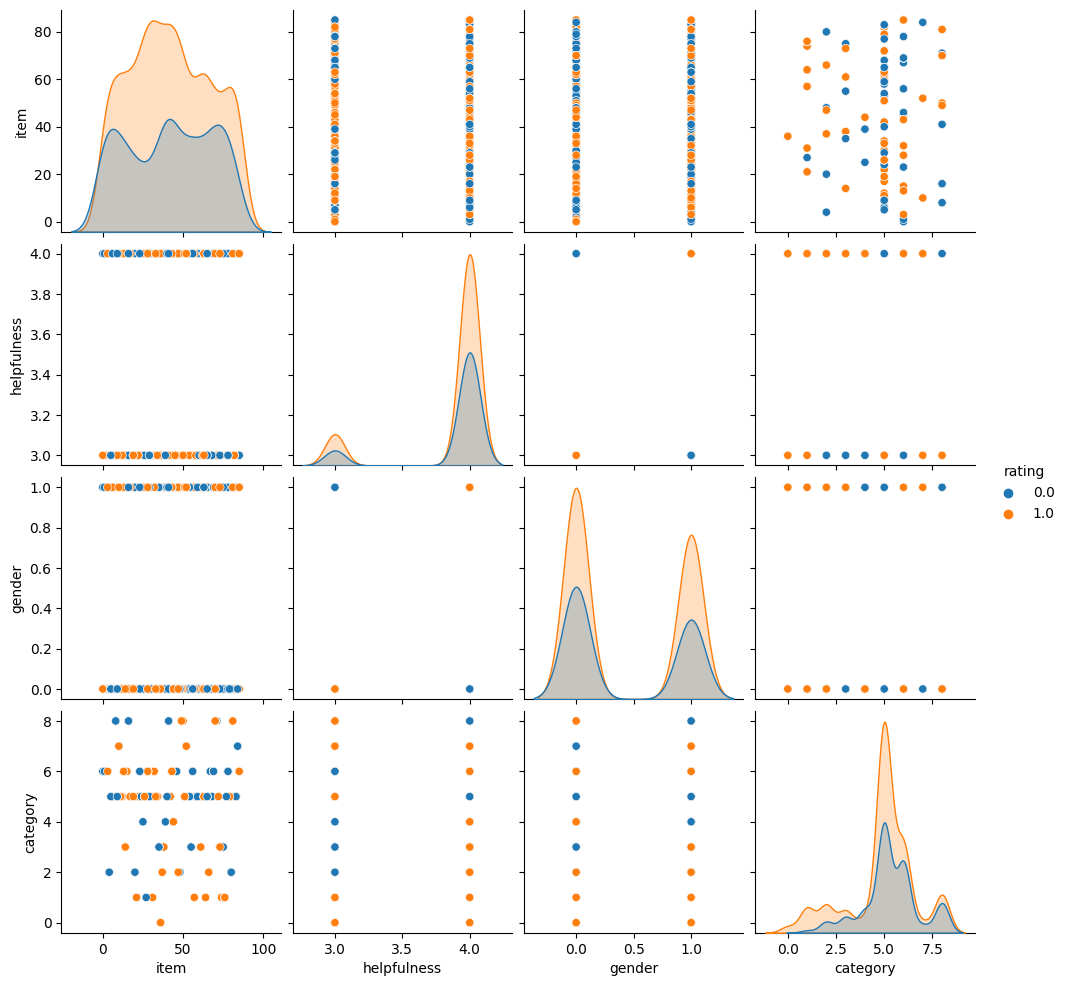

In [17]:
sns.pairplot(data=encodedProductDF.drop(columns=['userId','timestamp']), hue="rating")

#### <i>3) Study the correlation between these features.</i>

Now check the correlation of our dataset

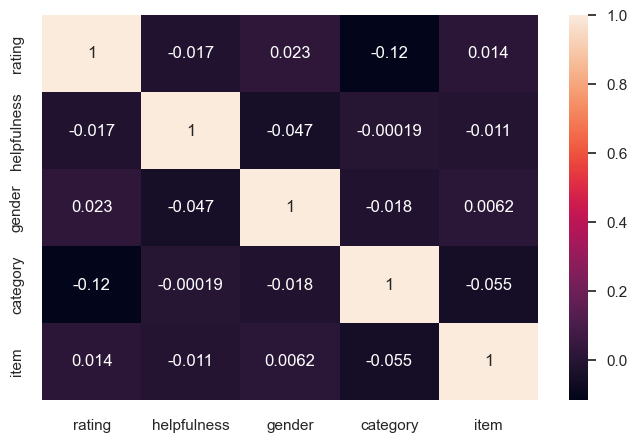

In [35]:
encodedProductDF = encodedProductDF[['rating', 'helpfulness', 'gender', 'category', 'item']]
plt.figure(figsize=(8,5))
sns.heatmap(encodedProductDF.corr(),annot=True)
plt.show()

In [36]:
encodedProductDF.corr()

,rating,helpfulness,gender,category,item
rating,1.000000,-0.016850,0.022576,-0.116312,0.013629
helpfulness,-0.016850,1.000000,-0.046627,-0.000189,-0.010780
gender,0.022576,-0.046627,1.000000,-0.017644,0.006231
category,-0.116312,-0.000189,-0.017644,1.000000,-0.054699
item,0.013629,-0.010780,0.006231,-0.054699,1.000000


## Train and Test Split - Logistic Regression

#### <i>4) Split the dataset and train a logistic regression model to predict 'rating' based on other features. Evaluate the accuracy of your model.</i>

Split our dataset in preparation for Logistic Regression

In [37]:
x = encodedProductDF.copy().drop(columns=['rating'])
y = encodedProductDF['rating'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Skim down the values of our x_train

In [38]:
x_train.head(5)

,helpfulness,gender,category,item
1907,4,0.0,5.0,17.0
163,4,1.0,5.0,42.0
1937,4,0.0,8.0,50.0
252,4,1.0,5.0,5.0
2231,4,0.0,5.0,7.0


Now, fit the model

In [22]:
regressor = LogisticRegression()
logModel = regressor.fit(x_train, y_train)
logModelPrediction = logModel.predict(x_test)

# check actual and predicted scores
dfPreds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': logModelPrediction.squeeze()})
dfPreds.head()

,Actual,Predicted
0,0.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


In [23]:
# Evaluation
maeLog = mean_absolute_error(y_test, logModelPrediction)
mseLog = mean_squared_error(y_test, logModelPrediction)
rmseLog = np.sqrt(mean_squared_error(y_test, logModelPrediction))
r2Log = r2_score(y_test, logModelPrediction)
accuracyLog = accuracy_score(y_test, logModelPrediction)

#Accurary Score
print("Accuracy: ", accuracyLog)
print(f'Mean absolute error: {maeLog:.3f}')
print(f'Mean squared error: {mseLog:.3f}')
print(f'Root mean squared error: {rmseLog:.2f}')
print(f'Adjusted R-Squared: {r2Log:.3f}')

#Metrics Data, we'll use this later to compare it against other model
metricsData = dict({'ModelName': ['Logistic-Regression'], 'Accuracy' : [accuracyLog], 'MAE': [maeLog], 'MSE': [mseLog], 'RMSE': [rmseLog], 'AdjustedRSquared':[r2Log]})

Accuracy:  0.6275862068965518
Mean absolute error: 0.372
Mean squared error: 0.372
Root mean squared error: 0.61
Adjusted R-Squared: -0.588


According to Mohammadhossein Saeedi of Texas Tech University, RMSE value 0.2 to 0.5 generally says that there function of the model is potential to have accurate prediction (Saeedi, 2019). In addition, Adjusted R-squared of 0.4 or more is also being accepted. However, let's try other algorithm, we may have better results.

## Train and Test Split - KNN

#### <i>5) Split the dataset and train a KNN model to predict 'rating' based on other features. You can set K with an ad-hoc manner in this step. Evaluate the accuracy of your model.</i>

In [24]:
encodedProductDF
knnDF = encodedProductDF.copy()

In [25]:
x = knnDF.copy().drop(columns=['rating']).values
y = knnDF['rating'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knnClassifier = KNeighborsClassifier(n_neighbors=7)
knnModel = knnClassifier.fit(x_train, y_train)
knnModelPrediction = knnModel.predict(x_test)

# check actual and predicted scores
dfPreds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': knnModelPrediction.squeeze()})
dfPreds

,Actual,Predicted
0,0.0,1.0
1,1.0,0.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
575,1.0,1.0
576,1.0,0.0
577,0.0,1.0
578,1.0,1.0


In [27]:
maeKnn = mean_absolute_error(y_test, knnModelPrediction)
mseKnn = mean_squared_error(y_test, knnModelPrediction)
rmseKnn = np.sqrt(mean_squared_error(y_test, knnModelPrediction))
r2Knn = r2_score(y_test, knnModelPrediction)
accuracyKnn = accuracy_score(y_test, knnModelPrediction)

#Accurary Score
print("Accuracy: ", accuracyKnn)
# Evaluation
print(f'Mean absolute error: {maeKnn:.2f}')
print(f'Mean squared error: {mseKnn:.2f}')
print(f'Root mean squared error: {rmseKnn:.2f}')
print(f'Adjusted R-Squared: {r2Knn:.3f}')

metricsData['ModelName'].append('KNN-7')
metricsData['Accuracy'].append(accuracyKnn)
metricsData['MAE'].append(maeKnn)
metricsData['MSE'].append(mseKnn)
metricsData['RMSE'].append(rmseKnn)
metricsData['AdjustedRSquared'].append(r2Knn)

Accuracy:  0.5706896551724138
Mean absolute error: 0.43
Mean squared error: 0.43
Root mean squared error: 0.66
Adjusted R-Squared: -0.830


Using K of 6, we have a good Adjusted R-Squared metric. This is an indication of good fit. Our RMSE outperforms the Logistic Regression too. Let's try another number of value for K by increasing it.

In [28]:
knnClassifier = KNeighborsClassifier(n_neighbors=9)
knnModel = knnClassifier.fit(x_train, y_train)
knnModelPrediction = knnModel.predict(x_test)

# check actual and predicted scores
dfPreds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': knnModelPrediction.squeeze()})
dfPreds

,Actual,Predicted
0,0.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
575,1.0,1.0
576,1.0,0.0
577,0.0,1.0
578,1.0,1.0


In [29]:
maeKnn = mean_absolute_error(y_test, knnModelPrediction)
mseKnn = mean_squared_error(y_test, knnModelPrediction)
rmseKnn = np.sqrt(mean_squared_error(y_test, knnModelPrediction))
r2Knn = r2_score(y_test, knnModelPrediction)
accuracyKnn = accuracy_score(y_test, knnModelPrediction)

#Accurary Score
print("Accuracy: ", accuracyKnn)
# Evaluation
print(f'Mean absolute error: {maeKnn:.2f}')
print(f'Mean squared error: {mseKnn:.2f}')
print(f'Root mean squared error: {rmseKnn:.2f}')
print(f'Adjusted R-Squared: {r2Knn:.3f}')

metricsData['ModelName'].append('KNN-9')
metricsData['Accuracy'].append(accuracyKnn)
metricsData['MAE'].append(maeKnn)
metricsData['MSE'].append(mseKnn)
metricsData['RMSE'].append(rmseKnn)
metricsData['AdjustedRSquared'].append(r2Knn)

Accuracy:  0.5862068965517241
Mean absolute error: 0.41
Mean squared error: 0.41
Root mean squared error: 0.64
Adjusted R-Squared: -0.764


#### <i>6) Tune the hyper-parameter K in KNN to see how it influences the prediction performance</i>
Not quite of what I was expecting. Maybe we could use the elbow tool to check the optimal value of K using the our dataset.

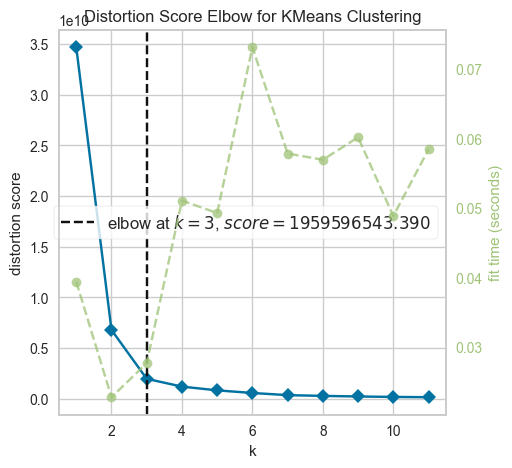

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
checkKMeansDF = knnDF.copy()
plt.figure(figsize=(5, 5))
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12)).fit(checkKMeansDF)
visualizer.show()

This is cool! We can use K = 3 then and check how it performs.

In [31]:
knnClassifier = KNeighborsClassifier(n_neighbors=3)
knnModel = knnClassifier.fit(x_train, y_train)
knnModelPrediction = knnModel.predict(x_test)

# check actual and predicted scores
dfPreds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': knnModelPrediction.squeeze()})
dfPreds

,Actual,Predicted
0,0.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,0.0
...,...,...
575,1.0,1.0
576,1.0,1.0
577,0.0,1.0
578,1.0,0.0


In [32]:
maeKnn = mean_absolute_error(y_test, knnModelPrediction)
mseKnn = mean_squared_error(y_test, knnModelPrediction)
rmseKnn = np.sqrt(mean_squared_error(y_test, knnModelPrediction))
r2Knn = r2_score(y_test, knnModelPrediction)
accuracyKnn = accuracy_score(y_test, knnModelPrediction)

#Accurary Score
print("Accuracy: ", accuracyKnn)
# Evaluation
print(f'Mean absolute error: {maeKnn:.2f}')
print(f'Mean squared error: {mseKnn:.2f}')
print(f'Root mean squared error: {rmseKnn:.2f}')
print(f'Adjusted R-Squared: {r2Knn:.3f}')

metricsData['ModelName'].append('KNN-3')
metricsData['Accuracy'].append(accuracyKnn)
metricsData['MAE'].append(maeKnn)
metricsData['MSE'].append(mseKnn)
metricsData['RMSE'].append(rmseKnn)
metricsData['AdjustedRSquared'].append(r2Knn)

Accuracy:  0.5482758620689655
Mean absolute error: 0.45
Mean squared error: 0.45
Root mean squared error: 0.67
Adjusted R-Squared: -0.926


## Visualize, Compare and Analyze the Results

In [33]:
metricsDF = pd.DataFrame(metricsData)
metricsDF

,ModelName,Accuracy,MAE,MSE,RMSE,AdjustedRSquared
0,Logistic-Regression,0.627586,0.372414,0.372414,0.610257,-0.587511
1,KNN-7,0.570690,0.429310,0.429310,0.655218,-0.830047
2,KNN-9,0.586207,0.413793,0.413793,0.643268,-0.763901
3,KNN-3,0.548276,0.451724,0.451724,0.672104,-0.925592


<Figure size 800x500 with 0 Axes>

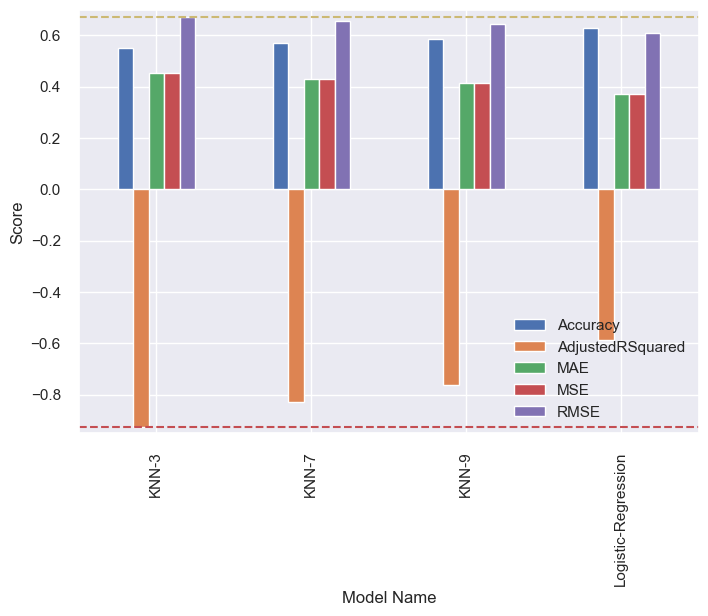

In [34]:
plt.figure(figsize=(8,5))
sns.set()  # use Seaborn styles
metricsDF.pivot_table(index="ModelName").plot(kind='bar')
plt.ylim(-0.95, 0.7)
plt.legend(loc='lower right')
plt.xlabel('Model Name')
plt.ylabel('Score')
plt.axhline(y = 0.672104, color = 'y', linestyle = '--')
plt.axhline(y = -0.925592, color = 'r', linestyle = '--')

As seen with the above figure, KNN Classification with K=3 outclassed Logistic Regression model in Adjusted R-Squared metric by a large margin and outmatched RMSE against other KNN models. It falls short with the accuracy though. I'd say our model is fairly good.